<a href="https://colab.research.google.com/github/sexymonster/Projects/blob/main/TeamProject/TomatoDataCustom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.인트로

## 1-1. 패키지 로드

In [1]:
from google.colab import drive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import matplotlib

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# 버전 오류를 잡아주는 코드
!pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 2.1 MB/s 
     |████████████████████████████████| 690 kB 38.2 MB/s 
     |████████████████████████████████| 4.7 MB 55.7 MB/s 
     |████████████████████████████████| 102 kB 43.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 44.0 MB/s 
     |████████████████████████████████| 296 kB 45.6 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=b56fe2795642dc1e87e9f0dcc2a7941004757019abff7caf301b118d76c46c91
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
Successfully built htmlmin
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: requests
   

## 1-2. 데이터 로드

In [3]:
path = "/content/gdrive/MyDrive/tomatoA/"

In [4]:
file_list = os.listdir(path)
print(file_list)

['2021_0010071_01', '2020_0020738_01', '2021_0020760_01', '2019_0010057_01']


## 1-3. 데이터 형태 수정

In [5]:
# 농가 번호를 입력하면 그 농가의 생육 정보(live), 제어 정보(ctrl), 환경 정보(env)들을 출력해주는 함수
def dataset(file, path=path):
  try:
    live = pd.read_excel(path + file+ "/방울토마토_생육정보_일별.xlsx")
    live = live.rename(columns = live.iloc[0])
    live = live.drop(live.index[0])
  except:
    pass

  ctrl = pd.read_excel(path + file+ "/방울토마토_제어정보_일별.xlsx")
  ctrl = ctrl.rename(columns = ctrl.iloc[0])
  ctrl = ctrl.drop(ctrl.index[0])

  env = pd.read_excel(path + file+ "/방울토마토_환경정보_일별.xlsx")
  env = env.rename(columns = env.iloc[0])
  env = env.drop(env.index[0])
  env = env.drop(env.columns[[3,5,6,9,10,11,13,14,19]], axis = 1)

  try:
    return live, ctrl, env
  except:
    return ctrl,env

In [6]:
# 모든 농가 데이터에 각각 번호(예를들면 ctrl1, ctrl2처럼)를 붙여줘서 출력해줌
file_list = os.listdir(path)

i = 1
live_list = []
ctrl_list = []
env_list= []

for file in file_list:
  try:
    globals()["live"+str(i)], globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # live_list.append(globals()["live"+str(i)])
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  except:
    globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  i += 1
print(i-1, '개의 농장 데이터가 있습니다.')

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


4 개의 농장 데이터가 있습니다.


# 2. 전처리

## 2-1. 데이터 전처리 함수

adapt(df) : 필요한 컬럼들로만 이루어진 데이터 프레임 생성\
astype(df) : 데이터들의 타입 변경 

### 2-1-1. 필요없는 컬럼 삭제해주는 함수 adapt()

In [7]:
# 유효한 컬럼을 알려주는 함수
def effcolm(df):
  effective = []
  columns = list(df)

  # 유효한 컬럼 추출 (nan값 개수가 1/3 이하인 컬럼)
  for col in columns:
    num_nan = df[col].isnull().sum()

    if num_nan < len(df[col])/3:
      effective.append(col)
  
  # 전부 0으로 표기된 의미 없는 컬럼도 제거(Nan,0.0이 같이 있으면 2개로 표시됨)
  for col in effective:
    if len(df[col].unique()) < 3:
      effective.remove(col) 


  return effective
  

In [8]:
# 유효한 컬럼으로만 이루어진 데이터프레임 생성
def adapt(df):
  eff_col = effcolm(df)
  df = df[eff_col]
  
  return df

### 2-1-2. Date를 인덱스로 설정하는 함수 astype()

In [9]:
# dtype변경 함수

def astype(df):
  # 수집일, 조사일의 데이터 형태를 datetime으로 변경하고, 인덱스로 설정
  df['Date'] = pd.to_datetime(df.iloc[:,0])
  df = df.set_index(keys="Date", drop = True)
  df = df.drop(df.columns[0], axis=1)

  # 나머지 데이터들의 형태를 float으로 변경
  df = df.astype("float")

  return df

### 2-1-3. 생육 데이터 자료의 변화량을 구해주는 함수 delta()

In [10]:
# 생육 데이터 자료의 변화량을 구해주는 함수
def delta(live):
  live_new = live[["주차","최종화방번호(번)"]]
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["생장길이(cm)"].pct_change()
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["화방높이(cm)"].pct_change()
  live_new["줄기굵기변화(dmm)"] = live.sort_values("Date")["줄기굵기(mm)"].pct_change()
  live_new["엽장변화(dcm)"] = live.sort_values("Date")["엽장(cm)"].pct_change()
  live_new["엽폭변화(dcm)"] = live.sort_values("Date")["엽폭(cm)"].pct_change()
  live_new["엽수변화(개)"] = live.sort_values("Date")["엽수(개)"].pct_change()
  live_new["개화군변화(점)"] = live.sort_values("Date")["개화군(점)"].pct_change()
  live_new["착과군변화(점)"] = live.sort_values("Date")["착과군(점)"].pct_change()
  live_new["열매수변화(개)"] = live.sort_values("Date")["열매수(개)"].pct_change()

  return live_new

### 2-1-4. adapt() 와 astype()을 동시에 실행시켜주는 함수 changedata()

In [11]:
def changedata(df):
  df = adapt(df)
  df = astype(df)
  
  return df

### 2-1-5. 생육데이터를 일 단위로 데이터 증강 시켜주는 함수 augment()

In [12]:
def augment(df):
  df_idx = df.index.to_list()
  print()
  idx = []
  growlist = []

  df_new = pd.DataFrame(columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
                           '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)'])
  for i in range(len(df_idx)-1):
    start = df_idx[i]
    start_gr = df.iloc[i,1]
    start_ht = df.iloc[i,2]
    start_th = df.iloc[i,3]
    start_ll = df.iloc[i,4]
    start_lw = df.iloc[i,5]
    start_ln = df.iloc[i,6]
    start_gh = df.iloc[i,7]
    start_ck = df.iloc[i,8]
    start_tm = df.iloc[i,9]
    start_nb = df.iloc[i,10]


    end = df_idx[i+1]
    end_gr = df.iloc[i+1,1]
    end_ht = df.iloc[i+1,2]
    end_th = df.iloc[i+1,3]
    end_ll = df.iloc[i+1,4]
    end_lw = df.iloc[i+1,5]
    end_ln = df.iloc[i+1,6]
    end_gh = df.iloc[i+1,7]
    end_ck = df.iloc[i+1,8]
    end_tm = df.iloc[i+1,9]
    end_nb = df.iloc[i+1,10]

    # print(start,start_gr,end,end_gr)
    diff = end_gr - start_gr
    dates = pd.date_range(start,end)
    inter = len(dates) - 1

    for j in range(inter):
      day = dates[j]
      growth = start_gr + (end_gr - start_gr)*j/(inter)
      height = start_ht + (end_ht - start_ht)*j/(inter)
      thick = start_th + (end_th - start_th)*j/(inter)
      lea_len = start_ll + (end_ll - start_ll)*j/(inter)
      lea_wid = start_lw + (end_lw - start_lw)*j/(inter)
      lea_num = start_ln + (end_ln - start_ln)*j/(inter)
      gaehwa = start_gh + (end_gh - start_gh)*j/(inter)
      chaka = start_ck + (end_ck - start_ck)*j/(inter)
      tomato = start_tm + (end_tm - start_tm)*j/(inter)
      numb = start_nb + (end_nb - start_nb)*j/(inter)
      

      df_new = df_new.append(pd.DataFrame([[day, growth, height, thick, lea_len, lea_wid, lea_num, gaehwa, chaka, tomato, numb]], columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
                            '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)']), ignore_index=True)
  df_new = astype(df_new)
  df_new = df_new.round(2)
  return df_new


## 2-2. 데이터 처리 과정

### 2-2-1. 환경데이터

In [13]:
env1 = changedata(env1)
env2 = changedata(env2)
env3 = changedata(env3)
env4 = changedata(env4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
env4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2019-12-24 to 2020-05-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   내부CO2(ppm)    33 non-null     float64
 1   내부습도(%)       33 non-null     float64
 2   강우감지          33 non-null     float64
 3   일사량(W/m-2·s)  33 non-null     float64
 4   외부온도(도)       33 non-null     float64
 5   내부온도(도)       33 non-null     float64
 6   외부풍속(m/s)     33 non-null     float64
dtypes: float64(7)
memory usage: 2.1 KB


In [15]:
# for i in range(len(new_live2)):
#   dlist = new_live2.index.to_list

#   for x in range(dlist[i],dlist[i+1]):
#       start = x
#       temp = new_live2[(new_live2["height"] >= start) & (new_live2["height"] < end)]
#       print("{}이상 {}미만 : {}".format(start, end, temp["height"].mean()))


### 2-2-2. 생육데이터

In [16]:
live1 = changedata(live1)
live2 = changedata(live2)
live3 = changedata(live3)
live4 = changedata(live4)

In [17]:
live2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17 entries, 2021-01-09 to 2021-04-28
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   주차         17 non-null     float64
 1   생장길이(cm)   17 non-null     float64
 2   화방높이(cm)   17 non-null     float64
 3   줄기굵기(mm)   17 non-null     float64
 4   엽장(cm)     17 non-null     float64
 5   엽폭(cm)     17 non-null     float64
 6   엽수(개)      17 non-null     float64
 7   개화군(점)     17 non-null     float64
 8   착과군(점)     17 non-null     float64
 9   열매수(개)     17 non-null     float64
 10  최종화방번호(번)  17 non-null     float64
dtypes: float64(11)
memory usage: 1.6 KB


In [18]:
live2

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2021-01-09,15.0,0.0,193.8,9.60,363.8,272.5,9.75,4.75,6.75,68.70,8.75
2021-01-13,16.0,13.7,208.0,9.90,377.5,278.0,10.00,4.25,7.00,90.00,8.50
2021-01-20,17.0,13.2,142.3,8.88,361.5,265.5,12.00,4.50,8.25,100.75,9.50
2021-01-27,18.0,22.5,160.0,10.40,340.5,278.5,12.75,4.25,9.00,102.75,10.00
2021-02-03,19.0,12.8,128.3,8.33,337.5,271.3,17.00,4.25,8.75,110.75,9.50
2021-02-10,20.0,7.5,147.5,9.25,396.3,355.0,16.00,4.25,8.75,112.25,9.25
2021-02-17,21.0,14.8,181.3,9.60,403.3,352.5,13.75,4.00,9.00,110.25,9.00
2021-02-24,22.0,18.5,207.3,10.30,312.5,275.0,14.00,3.00,9.00,78.43,9.50
2021-03-03,23.0,10.8,187.8,9.60,317.5,287.5,15.50,3.75,9.00,101.25,10.00


### 2-2-2(1). 생육데이터 증강

In [19]:
new_live1 = augment(live1)
new_live2 = augment(live2)
new_live3 = augment(live3)
new_live4 = augment(live4)

In [20]:
new_live1

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-20,0.00,0.0,2.09,89.30,54.00,6.50,0.0,0.00,0.00,0.00
2021-01-21,9.64,0.0,2.16,91.90,56.29,6.79,0.0,0.00,0.00,0.00
2021-01-22,19.29,0.0,2.23,94.50,58.57,7.07,0.0,0.00,0.00,0.00
2021-01-23,28.93,0.0,2.30,97.10,60.86,7.36,0.0,0.00,0.00,0.00
2021-01-24,38.57,0.0,2.38,99.70,63.14,7.64,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
2021-06-25,0.00,0.0,7.07,374.16,302.00,11.46,0.0,2.89,27.82,2.89
2021-06-26,0.00,0.0,7.52,387.49,322.50,11.32,0.0,2.71,24.61,2.71
2021-06-27,0.00,0.0,7.98,400.81,343.00,11.18,0.0,2.54,21.39,2.54


In [ ]:
del_live2 = delta(live2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
# live2_idx = live2.index.to_list()
# idx = []
# growlist = []
# df = pd.DataFrame(columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
#                            '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)'])
# for i in range(len(live2_idx)-1):
#   start = live2_idx[i]
#   start_gr = live2.iloc[i,1]
#   start_ht = live2.iloc[i,2]
#   start_th = live2.iloc[i,3]
#   start_ll = live2.iloc[i,4]
#   start_lw = live2.iloc[i,5]
#   start_ln = live2.iloc[i,6]
#   start_gh = live2.iloc[i,7]
#   start_ck = live2.iloc[i,8]
#   start_tm = live2.iloc[i,9]
#   start_nb = live2.iloc[i,10]


#   end = live2_idx[i+1]
#   end_gr = live2.iloc[i+1,1]
#   end_ht = live2.iloc[i+1,2]
#   end_th = live2.iloc[i+1,3]
#   end_ll = live2.iloc[i+1,4]
#   end_lw = live2.iloc[i+1,5]
#   end_ln = live2.iloc[i+1,6]
#   end_gh = live2.iloc[i+1,7]
#   end_ck = live2.iloc[i+1,8]
#   end_tm = live2.iloc[i+1,9]
#   end_nb = live2.iloc[i+1,10]

#   # print(start,start_gr,end,end_gr)
#   diff = end_gr - start_gr
#   dates = pd.date_range(start,end)
#   inter = len(dates) - 1

#   for j in range(inter):
#     day = dates[j]
#     growth = start_gr + (end_gr - start_gr)*j/(inter)
#     height = start_ht + (end_ht - start_ht)*j/(inter)
#     thick = start_th + (end_th - start_th)*j/(inter)
#     lea_len = start_ll + (end_ll - start_ll)*j/(inter)
#     lea_wid = start_lw + (end_lw - start_lw)*j/(inter)
#     lea_num = start_ln + (end_ln - start_ln)*j/(inter)
#     gaehwa = start_gh + (end_gh - start_gh)*j/(inter)
#     chaka = start_ck + (end_ck - start_ck)*j/(inter)
#     tomato = start_tm + (end_tm - start_tm)*j/(inter)
#     numb = start_nb + (end_nb - start_nb)*j/(inter)
    

#     df = df.append(pd.DataFrame([[day, growth, height, thick, lea_len, lea_wid, lea_num, gaehwa, chaka, tomato, numb]], columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
#                            '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)']), ignore_index=True)



In [21]:
new_live1.iloc[70:80,:].round(2)

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-03-31,140.00,167.50,10.01,450.00,325.00,22.75,0.88,0.65,3.75,4.50
2021-04-01,127.14,162.50,9.89,436.19,315.86,21.50,0.83,0.80,3.96,4.46
2021-04-02,114.29,157.50,9.77,422.37,306.71,20.25,0.79,0.96,4.18,4.43
2021-04-03,101.43,152.50,9.65,408.56,297.57,19.00,0.74,1.11,4.39,4.39
2021-04-04,88.57,147.50,9.53,394.74,288.43,17.75,0.69,1.27,4.61,4.36
2021-04-05,75.71,142.50,9.41,380.93,279.29,16.50,0.64,1.42,4.82,4.32
2021-04-06,62.86,137.50,9.29,367.11,270.14,15.25,0.60,1.58,5.04,4.29
2021-04-07,50.00,132.50,9.17,353.30,261.00,14.00,0.55,1.73,5.25,4.25
2021-04-08,52.33,126.07,8.83,354.37,256.71,13.86,0.55,1.98,6.18,4.32


### 2-2-3. 제어 데이터

In [22]:
ctrl1 = changedata(ctrl1)
ctrl2 = changedata(ctrl2)
ctrl3 = changedata(ctrl3)
ctrl4 = changedata(ctrl4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
ctrl2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2021-02-01 to 2021-04-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   좌측일중천창 작동여부  86 non-null     float64
 1   우측일중천창 작동여부  86 non-null     float64
 2   우측이중천창 작동여부  86 non-null     float64
 3   차광커튼작동상태     86 non-null     float64
dtypes: float64(4)
memory usage: 3.4 KB


In [24]:
ctrl2

,좌측일중천창 작동여부,우측일중천창 작동여부,우측이중천창 작동여부,차광커튼작동상태
Date,,,,
2021-02-01,0.00,0.00,0.0,23.94
2021-02-02,0.00,1.80,0.0,27.64
2021-02-03,0.29,2.79,0.0,32.32
2021-02-04,1.44,2.05,0.0,34.83
2021-02-05,3.32,2.81,0.0,36.99
...,...,...,...,...
2021-04-26,20.43,23.15,0.0,56.10
2021-04-27,14.29,15.55,0.0,61.51
2021-04-28,11.80,18.64,0.0,50.31


# 3. 시각화

In [25]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=new_live1.index, y=new_live1['화방높이(cm)'], mode='lines+markers', name='height'))
fig.add_trace(go.Scatter(x=new_live1.index, y=new_live1['줄기굵기(mm)'], mode='lines+markers', name='tick'))
fig.add_trace(go.Scatter(x=new_live1.index, y=new_live1['엽장(cm)'], mode='lines+markers', name='leaf_len'))
fig.add_trace(go.Scatter(x=new_live1.index, y=new_live1['엽폭(cm)'], mode='lines+markers', name='leaf_wide'))
fig.add_trace(go.Scatter(x=new_live1.index, y=new_live1['열매수(개)'], mode='lines+markers', name='tomato'))


fig.update_layout(
    title='Tomato (Jan 2018 - Jan 2020)',
    xaxis_title='Date', yaxis_title='lenght(cm)'
)

## 3-1. live

In [ ]:
print(live2.corr())

                 주차  생장길이(cm)  화방높이(cm)  줄기굵기(mm)    엽장(cm)    엽폭(cm)  \
주차         1.000000 -0.412521  0.050332  0.445992  0.739724  0.787115   
생장길이(cm)  -0.412521  1.000000  0.542720  0.160292 -0.085487 -0.220019   
화방높이(cm)   0.050332  0.542720  1.000000  0.706385  0.464763  0.370209   
줄기굵기(mm)   0.445992  0.160292  0.706385  1.000000  0.871426  0.797572   
엽장(cm)     0.739724 -0.085487  0.464763  0.871426  1.000000  0.974690   
엽폭(cm)     0.787115 -0.220019  0.370209  0.797572  0.974690  1.000000   
엽수(개)      0.156551  0.360195  0.378990  0.606898  0.595988  0.507825   
개화군(점)     0.225424  0.358743  0.702861  0.556031  0.437203  0.338765   
착과군(점)     0.826232 -0.237101  0.027184  0.139683  0.417512  0.448837   
열매수(개)     0.731368 -0.325822 -0.170435  0.023386  0.345404  0.380361   
최종화방번호(번)  0.733735  0.041079  0.456737  0.481204  0.605250  0.576442   

              엽수(개)    개화군(점)    착과군(점)    열매수(개)  최종화방번호(번)  
주차         0.156551  0.225424  0.826232  0.731368   0.733735

In [ ]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부습도(%)'], mode='lines+markers', name='sub1'))
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부온도(도)'], mode='lines+markers', name='tem1'))
fig.add_trace(go.Scatter(x=env1.index, y=env1['일사량(W/m-2·s)'], mode='lines+markers', name='sun1'))

fig.add_trace(go.Scatter(x=env3.index, y=env3['내부습도(%)'], mode='lines+markers', name='sub3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['내부온도(도)'], mode='lines+markers', name='tem3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['일사량(W/m-2·s)'], mode='lines+markers', name='sun3'))

In [99]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부온도(도)'], mode='lines+markers', name='tem1'))

fig.add_trace(go.Scatter(x=env2.index, y=env2['내부온도(도)'], mode='lines+markers', name='tem2'))

fig.add_trace(go.Scatter(x=env3.index, y=env3['내부온도(도)'], mode='lines+markers', name='tem3'))

fig.add_trace(go.Scatter(x=env4.index, y=env4['내부온도(도)'], mode='lines+markers', name='tem4'))

In [94]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=live1.index, y=live1['열매수(개)'], mode='lines+markers', name='tomato1'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato2'))
fig.add_trace(go.Scatter(x=live3.index, y=live3['열매수(개)'], mode='lines+markers', name='tomato3'))
fig.add_trace(go.Scatter(x=live4.index, y=live4['열매수(개)'], mode='lines+markers', name='tomato4'))

In [ ]:
new_live2.iloc[:10,:]

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-09,0.00,193.80,9.60,363.80,272.50,9.75,4.75,6.75,68.70,8.75
2021-01-10,3.42,197.35,9.68,367.22,273.88,9.81,4.62,6.81,74.03,8.69
2021-01-11,6.85,200.90,9.75,370.65,275.25,9.88,4.50,6.88,79.35,8.62
2021-01-12,10.27,204.45,9.82,374.08,276.62,9.94,4.38,6.94,84.68,8.56
2021-01-13,13.70,208.00,9.90,377.50,278.00,10.00,4.25,7.00,90.00,8.50
2021-01-14,13.63,198.61,9.75,375.21,276.21,10.29,4.29,7.18,91.54,8.64
2021-01-15,13.56,189.23,9.61,372.93,274.43,10.57,4.32,7.36,93.07,8.79
2021-01-16,13.49,179.84,9.46,370.64,272.64,10.86,4.36,7.54,94.61,8.93
2021-01-17,13.41,170.46,9.32,368.36,270.86,11.14,4.39,7.71,96.14,9.07


In [40]:
live3.iloc[5:15,:]

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2022-01-01,23.0,202.5,235.0,11.54,443.75,442.50,10.75,16.44,15.90,83.25,17.00
2022-01-06,24.0,175.0,157.5,9.95,482.00,419.00,12.75,17.20,16.49,80.50,18.00
2022-01-15,25.0,182.5,322.5,10.48,446.00,408.00,8.50,17.43,17.34,81.75,18.00
2022-01-22,26.0,187.5,242.5,10.43,454.50,382.25,11.50,18.33,17.42,83.50,19.00
2022-01-29,27.0,220.0,120.0,7.71,437.25,367.00,10.50,19.10,18.25,89.75,20.00
2022-02-05,28.0,220.0,315.0,10.32,451.75,397.75,7.50,19.76,19.43,92.00,20.25
2022-02-12,29.0,227.5,167.5,8.68,435.50,342.50,7.50,20.29,19.41,92.75,21.00
2022-02-19,30.0,177.5,147.5,6.96,406.75,308.25,10.00,20.98,20.29,88.25,21.75
2022-02-26,31.0,180.0,242.5,9.01,363.75,363.75,8.00,21.28,20.69,85.50,21.75


In [ ]:
corr_df = live2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr']) # s==1 은 자기자신이기 때문에 제외
df.style.background_gradient(cmap='viridis')

,,corr
엽폭(cm),엽장(cm),0.970000
엽장(cm),엽폭(cm),0.970000
착과군(점),열매수(개),0.920000
열매수(개),착과군(점),0.920000
줄기굵기(mm),엽장(cm),0.870000
엽장(cm),줄기굵기(mm),0.870000
착과군(점),최종화방번호(번),0.860000
최종화방번호(번),착과군(점),0.860000
주차,착과군(점),0.830000
착과군(점),주차,0.830000


## 3-2. env

In [ ]:
print(env2.corr())

              내부CO2(ppm)   내부습도(%)      강우감지  일사량(W/m-2·s)   외부온도(도)  \
내부CO2(ppm)      1.000000 -0.190374  0.106662     -0.422267 -0.741889   
내부습도(%)        -0.190374  1.000000  0.405624     -0.304710  0.344375   
강우감지            0.106662  0.405624  1.000000     -0.510946  0.053641   
일사량(W/m-2·s)   -0.422267 -0.304710 -0.510946      1.000000  0.466237   
외부온도(도)        -0.741889  0.344375  0.053641      0.466237  1.000000   
내부온도(도)        -0.732016  0.135669 -0.137231      0.575753  0.821146   
지온(도)          -0.759758  0.151117 -0.084324      0.447783  0.907718   
외부풍속(m/s)      -0.104698  0.054309  0.093670     -0.064576  0.001221   

               내부온도(도)     지온(도)  외부풍속(m/s)  
내부CO2(ppm)   -0.732016 -0.759758  -0.104698  
내부습도(%)       0.135669  0.151117   0.054309  
강우감지         -0.137231 -0.084324   0.093670  
일사량(W/m-2·s)  0.575753  0.447783  -0.064576  
외부온도(도)       0.821146  0.907718   0.001221  
내부온도(도)       1.000000  0.944606  -0.158054  
지온(도)         0.944606  1.000

In [ ]:
corr_df = env2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

,,corr
내부온도(도),지온(도),0.940000
지온(도),내부온도(도),0.940000
외부온도(도),지온(도),0.910000
지온(도),외부온도(도),0.910000
내부온도(도),외부온도(도),0.820000
외부온도(도),내부온도(도),0.820000
내부온도(도),일사량(W/m-2·s),0.580000
일사량(W/m-2·s),내부온도(도),0.580000
외부온도(도),일사량(W/m-2·s),0.470000
일사량(W/m-2·s),외부온도(도),0.470000


## 3-3. ctrl

In [ ]:
print(ctrl2.corr())

             좌측일중천창 작동여부  우측일중천창 작동여부  좌측이중천창 작동여부  우측이중천창 작동여부  좌측일중측창 작동여부  \
좌측일중천창 작동여부     1.000000     0.924604     0.858802     0.841724     0.895373   
우측일중천창 작동여부     0.924604     1.000000     0.789814     0.907732     0.870756   
좌측이중천창 작동여부     0.858802     0.789814     1.000000     0.852091     0.818982   
우측이중천창 작동여부     0.841724     0.907732     0.852091     1.000000     0.833715   
좌측일중측창 작동여부     0.895373     0.870756     0.818982     0.833715     1.000000   
차광커튼작동상태        0.737078     0.739025     0.553559     0.588440     0.672576   

             차광커튼작동상태  
좌측일중천창 작동여부  0.737078  
우측일중천창 작동여부  0.739025  
좌측이중천창 작동여부  0.553559  
우측이중천창 작동여부  0.588440  
좌측일중측창 작동여부  0.672576  
차광커튼작동상태     1.000000  


In [ ]:
corr_df = ctrl2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

In [ ]:
env2.columns

Index(['내부CO2(ppm)', '내부습도(%)', '강우감지', '일사량(W/m-2·s)', '외부온도(도)', '내부온도(도)',
       '지온(도)', '외부풍속(m/s)'],
      dtype='object')

In [41]:
new_live1

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-20,0.00,0.0,2.09,89.30,54.00,6.50,0.0,0.00,0.00,0.00
2021-01-21,9.64,0.0,2.16,91.90,56.29,6.79,0.0,0.00,0.00,0.00
2021-01-22,19.29,0.0,2.23,94.50,58.57,7.07,0.0,0.00,0.00,0.00
2021-01-23,28.93,0.0,2.30,97.10,60.86,7.36,0.0,0.00,0.00,0.00
2021-01-24,38.57,0.0,2.38,99.70,63.14,7.64,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
2021-06-25,0.00,0.0,7.07,374.16,302.00,11.46,0.0,2.89,27.82,2.89
2021-06-26,0.00,0.0,7.52,387.49,322.50,11.32,0.0,2.71,24.61,2.71
2021-06-27,0.00,0.0,7.98,400.81,343.00,11.18,0.0,2.54,21.39,2.54


In [27]:
df_merge1 = pd.merge(new_live1, env1, left_index=True, right_index=True, how='outer')
df_merge2 = pd.merge(new_live2, env2, left_index=True, right_index=True, how='outer')
df_merge3 = pd.merge(new_live3, env3, left_index=True, right_index=True, how='outer')
df_merge4 = pd.merge(new_live4, env4, left_index=True, right_index=True, how='outer')

In [31]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2021-01-12 to 2021-06-30
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   생장길이(cm)      161 non-null    float64
 1   화방높이(cm)      161 non-null    float64
 2   줄기굵기(mm)      161 non-null    float64
 3   엽장(cm)        161 non-null    float64
 4   엽폭(cm)        161 non-null    float64
 5   엽수(개)         161 non-null    float64
 6   개화군(점)        161 non-null    float64
 7   착과군(점)        161 non-null    float64
 8   열매수(개)        161 non-null    float64
 9   최종화방번호(번)     161 non-null    float64
 10  내부CO2(ppm)    167 non-null    float64
 11  내부습도(%)       167 non-null    float64
 12  지습(%)         131 non-null    float64
 13  강우감지          167 non-null    float64
 14  일사량(W/m-2·s)  167 non-null    float64
 15  외부온도(도)       167 non-null    float64
 16  내부온도(도)       167 non-null    float64
 17  지온(도)         131 non-null    float64
 18  외부풍속(m/s)  

# Modeling

생육, 환경 데이터 df_merge1,df_merge2,df_merge3,df_merge4

In [97]:
df_merge4.head()

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번),내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s)
Date,,,,,,,,,,,,,,,,,
2019-12-07,1807.50,172.50,10.54,382.50,212.5,15.50,5.04,3.91,27.00,5.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-08,1567.14,182.86,10.51,377.86,220.0,14.04,5.18,4.06,28.54,5.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-09,1326.79,193.21,10.48,373.21,227.5,12.57,5.31,4.21,30.07,6.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-10,1086.43,203.57,10.45,368.57,235.0,11.11,5.45,4.36,31.61,6.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,846.07,213.93,10.43,363.93,242.5,9.64,5.58,4.52,33.14,6.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# 농가 1) Nan값 삭제
ndf_merge1 = df_merge1[df_merge1["지습(%)"].isnull() == False ]
# ndf_merge1 = ndf_merge1[ndf_merge1["강우감지"].isnull() == False ]
ndf_merge1 = ndf_merge1.iloc[:-1 , :]

In [64]:
# 농가 2) Nan값 삭제
ndf_merge2 = df_merge2[df_merge2["지온(도)"].isnull() == False ]
# ndf_merge1 = ndf_merge1[ndf_merge1["강우감지"].isnull() == False ]
ndf_merge2 = ndf_merge2.iloc[:-3 , :]

In [75]:
# 농가 3) Nan값 삭제
ndf_merge3 = df_merge3[df_merge3["열매수(개)"].isnull() == False ]
ndf_merge3 = ndf_merge3[df_merge3["외부온도(도)"].isnull() == False ]
ndf_merge3 = ndf_merge3[df_merge3["지온(도)"].isnull() == False ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [76]:
ndf_merge3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2021-11-27 to 2022-01-02
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   생장길이(cm)      37 non-null     float64
 1   화방높이(cm)      37 non-null     float64
 2   줄기굵기(mm)      37 non-null     float64
 3   엽장(cm)        37 non-null     float64
 4   엽폭(cm)        37 non-null     float64
 5   엽수(개)         37 non-null     float64
 6   개화군(점)        37 non-null     float64
 7   착과군(점)        37 non-null     float64
 8   열매수(개)        37 non-null     float64
 9   최종화방번호(번)     37 non-null     float64
 10  내부CO2(ppm)    37 non-null     float64
 11  이슬점온도(도)      37 non-null     float64
 12  토양EC(dS/m)    37 non-null     float64
 13  내부습도(%)       37 non-null     float64
 14  지습(%)         37 non-null     float64
 15  강우감지          37 non-null     float64
 16  일사량(W/m-2·s)  37 non-null     float64
 17  외부온도(도)       37 non-null     float64
 18  내부온도(도)     

In [52]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

## 4-1. LSTM

In [84]:
# 농가 1로 학습하고 농가 3로 테스트
x_3 = array(ndf_merge3[["내부습도(%)","지습(%)","일사량(W/m-2·s)","외부온도(도)","내부온도(도)"]])
y_3 = array(ndf_merge3["열매수(개)"])

In [85]:
x = array(ndf_merge1[["내부습도(%)","지습(%)","일사량(W/m-2·s)","외부온도(도)","내부온도(도)"]])
y = array(ndf_merge1["열매수(개)"])
print(x.shape)
print(y.shape)
x = x.reshape((x.shape[0], x.shape[1],1))
print(x.shape)

model = Sequential()
model.add(LSTM(20, activation = "relu", input_shape = (5,1)))
model.add(Dense(5))
model.add(Dense(1))
model.summary()


model.compile(optimizer = "adam", loss = "mse")

early_stopping = EarlyStopping(monitor = "loss", patience = 100, mode = "auto")

# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
history = model.fit(x, y, 
                    epochs = 1000,
                    batch_size = 1,
                    verbose = 2,
                    callbacks = [early_stopping],
                    validation_data=(x_3,y_3))

(125, 5)
(125,)
(125, 5, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                1760      
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
125/125 - 2s - loss: 1165.5955 - val_loss: 6872.0151 - 2s/epoch - 18ms/step
Epoch 2/1000
125/125 - 1s - loss: 656.7711 - val_loss: 7882.4829 - 505ms/epoch - 4ms/step
Epoch 3/1000
125/125 - 0s - loss: 502.1948 - val_loss: 9228.9902 - 491ms/epoch - 4ms/step
Epoch 4/1000
125/12

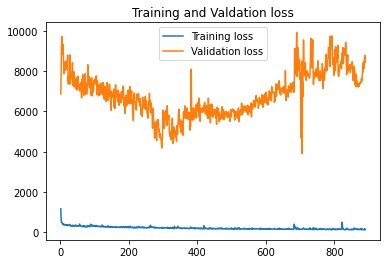

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()

### 4-1-1. 특징값 정규화

Min-Max 정규화

In [ ]:
# normalization_df = (df - df.mean())/df.std()
# normalization_df.head()

In [92]:
x = array(ndf_merge1[["내부습도(%)","지습(%)","일사량(W/m-2·s)","내부온도(도)"]])
y = array(ndf_merge1["열매수(개)"])

x_3 = array(ndf_merge3[["내부습도(%)","지습(%)","일사량(W/m-2·s)","내부온도(도)"]])
y_3 = array(ndf_merge3["열매수(개)"])

x1_norm = (x-x.mean())/x.std()
x3_norm = (x_3-x_3.mean())/x_3.std()

print(x1_norm.shape)
print(y.shape)
x1_norm = x1_norm.reshape((x1_norm.shape[0], x1_norm.shape[1],1))
print(x1_norm.shape)

model = Sequential()
model.add(LSTM(20, activation = "relu", input_shape = (4,1)))
model.add(Dense(5))
model.add(Dense(1))
model.summary()


model.compile(optimizer = "adam", loss = "mse")

early_stopping = EarlyStopping(monitor = "loss", patience = 100, mode = "auto")

# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
history = model.fit(x1_norm, y, 
                    epochs = 1000,
                    batch_size = 1,
                    verbose = 2,
                    callbacks = [early_stopping],
                    validation_data=(x3_norm,y_3))

(125, 4)
(125,)
(125, 4, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 20)                1760      
                                                                 
 dense_10 (Dense)            (None, 5)                 105       
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
125/125 - 2s - loss: 2012.7997 - val_loss: 6938.5693 - 2s/epoch - 20ms/step
Epoch 2/1000
125/125 - 0s - loss: 1333.8469 - val_loss: 4114.8203 - 369ms/epoch - 3ms/step
Epoch 3/1000
125/125 - 0s - loss: 1104.8319 - val_loss: 4149.5034 - 375ms/epoch - 3ms/step
Epoch 4/1000
125/

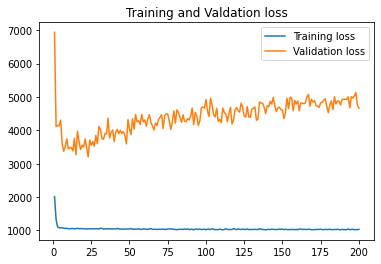

In [93]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()

In [ ]:
ndf_merge4.describe()

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번),...,이슬점온도(도),토양EC(dS/m),내부습도(%),지습(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),지온(도),외부풍속(m/s)
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.00000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,181.405405,225.371622,9.479189,452.801351,384.737838,11.064865,15.309730,14.541622,86.275676,15.931081,...,11.086216,0.982162,58.21000,70.651892,0.030000,92.150541,0.548378,9.265405,14.406757,0.824324
std,56.621135,35.061554,0.956011,19.346166,28.293893,0.724629,0.797041,1.003279,4.255255,0.800357,...,0.799494,0.030654,2.38464,0.973498,0.086538,33.945081,3.418415,0.525751,0.637561,0.826907
min,0.000000,138.750000,7.390000,419.000000,344.750000,10.000000,13.840000,12.930000,77.000000,14.500000,...,8.500000,0.880000,53.94000,68.550000,0.000000,5.230000,-8.370000,8.070000,12.840000,0.080000
25%,176.790000,214.820000,9.170000,436.680000,363.390000,10.570000,14.680000,13.660000,83.250000,15.290000,...,10.730000,0.980000,56.44000,70.140000,0.000000,65.290000,-0.860000,8.990000,13.910000,0.250000
50%,193.930000,233.210000,9.540000,451.680000,379.610000,10.860000,15.390000,14.540000,86.790000,16.000000,...,11.160000,1.000000,58.25000,70.700000,0.000000,105.230000,1.240000,9.380000,14.590000,0.540000
75%,209.640000,239.500000,9.860000,470.320000,398.960000,11.500000,15.970000,15.540000,89.320000,16.640000,...,11.730000,1.000000,60.04000,71.430000,0.000000,121.290000,3.100000,9.640000,14.800000,1.210000
max,252.500000,290.000000,11.540000,482.250000,442.500000,12.750000,16.590000,16.020000,93.750000,17.200000,...,12.030000,1.000000,63.78000,72.030000,0.480000,139.670000,5.320000,10.070000,15.450000,3.150000


In [ ]:
env1

,내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s)
Date,,,,,,,
2019-12-24,284.44,83.22,0.00,0.42,1.09,11.58,0.57
2019-12-25,411.51,84.80,0.00,66.41,2.18,14.10,0.86
2019-12-26,424.04,89.44,0.19,16.37,3.98,12.20,1.29
2019-12-27,367.24,83.28,0.00,108.61,0.81,14.44,0.70
2019-12-28,353.65,82.62,0.00,105.49,-0.15,14.30,0.39
2019-12-29,392.29,87.90,0.40,37.29,2.02,12.94,1.07
2019-12-30,432.46,90.14,0.11,29.97,4.92,12.91,0.96
2019-12-31,365.54,82.94,0.00,113.95,-3.85,13.97,1.46
2020-01-01,352.02,86.28,0.00,72.82,-2.16,13.34,0.49


In [ ]:
ctrl1

,좌측일중천창 작동여부,우측일중천창 작동여부,차광커튼작동상태
Date,,,
2019-12-24,0.00,0.00,12.89
2019-12-25,0.00,1.78,24.12
2019-12-26,0.00,0.00,25.46
2019-12-27,0.36,1.39,23.40
2019-12-28,0.44,2.44,22.46
2019-12-29,0.00,0.38,26.06
2019-12-30,1.98,0.96,25.88
2019-12-31,1.41,0.12,21.41
2020-01-01,1.28,0.00,20.04
